In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from functools import partial
from sklearn.utils import class_weight

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)
session = tf.compat.v1.InteractiveSession(config=config)

sns.set_style("darkgrid")
sns.set_context("talk")


Num GPUs Available:  1


In [2]:
def ressizer(image_tensor):
    dim = (299, 299)
    resized  = cv2.resize(image_tensor, dim)
    
    print('Resized Dimensions : ',resized.shape)
#     cv2.imshow("Resized image", resized)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    return resized

def cropper(image_tensor):
    SIZE = 299

    width, height  = image_tensor.shape[0:2]

    reduce_pixel_count = (width - SIZE  , height - SIZE)

    rng = np.random.default_rng()
    startRow = rng.integers(0, high=reduce_pixel_count[0], endpoint=True)
    startCol = rng.integers(0, high=reduce_pixel_count[1], endpoint=True)
    endRow = reduce_pixel_count[0] - startRow
    endCol = reduce_pixel_count[1] - startCol


    cropped_image = image_tensor[startRow:width-endRow, startCol:height-endCol]
   
    return cropped_image

In [3]:
my_dir = os.getcwd()  # grabs current work dir
all_file_paths = os.listdir()  # grabs all items in current work dir

FOLDER_TO_ACCESS = 'blob'
data_path = [data for data in all_file_paths if FOLDER_TO_ACCESS in data.lower()]  # searches for data folder and retrieves
train_folder_path = os.path.join(my_dir, data_path[0])  # joins data folder and current work dir to get picture path
all_classifications = os.listdir(train_folder_path)  # list of classification fodlers
all_classifications

['0', '1', '2', '3', '4']

### Distribution of Data

Classification 0 = 38.275% or 488 images
Classification 1 = 25.804% or 329 images
Classification 2 = 10.196% or 130 images
Classification 3 = 10.275% or 131 images
Classification 4 = 15.451% or 197 images


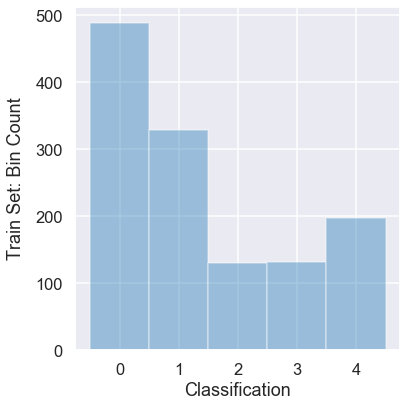

In [34]:
df_Train = pd.read_csv('TrainAnnotations.csv')
df_Train['annotation_string']=df_Train['annotation'].astype('str') # for KERAS

fig, axe = plt.subplots(figsize=(6, 6))
bin_val = np.arange(0, 6, 1) - 0.5
sns.distplot(df_Train['annotation'], kde=False, bins=bin_val)
# plt.xlim(-0.1,4.1)
plt.xticks(np.arange(0,5, 1))
plt.ylabel("Train Set: Bin Count", labelpad=10)
plt.xlabel('Classification')
plt.tight_layout()

df_Train['annotation'].value_counts(normalize=True)

string_print = []
for i in range(5):
    val = df_Train.annotation.value_counts(normalize=True, sort=False).iloc[i]*100
    val_count = df_Train.annotation.value_counts(normalize=False, sort=False).iloc[i]
    string_print.append(f'Classification {i} = {val:.3f}% or {val_count} images')
print(*string_print, sep='\n')


In [5]:
# my_classes = np.sort(df_Train.annotation.unique())  # unique values, sort from small to largest
# classification_weight = class_weight.compute_class_weight('balanced', my_classes,df_Train.annotation.values)
# classification_weight

In [6]:
# IM_ORIG = np.array([640, 480])
# IM_SCALE = 2

# IM = IM_ORIG / IM_SCALE
# IM = [int(x) for x in np.append(IM, 3).tolist()]

IM = (299, 299)  #Desired Image Dimension to work with
# IM = (640, 480)

# train_datagen = ImageDataGenerator(
#     validation_split=0.2) # set validation split


train_datagen = ImageDataGenerator(rescale=1./255,
                                   preprocessing_function=cropper,
                                   validation_split=0.2)


train_it = train_datagen.flow_from_directory(train_folder_path,
                                             target_size = (299, 299),
                                             subset='training',
                                             class_mode='sparse',
                                             shuffle=True,
                                             batch_size=28)

validate_it = train_datagen.flow_from_directory(train_folder_path,
                                                target_size = (299, 299),
                                                subset='validation',
                                                class_mode='sparse',
                                                shuffle=True,
                                                batch_size=28)

Found 1955 images belonging to 5 classes.
Found 485 images belonging to 5 classes.


In [7]:
model = keras.models.Sequential()

# new_input = keras.Input(shape=IM)
model.add(InceptionV3(include_top=False, input_shape=(299, 299, 3), weights="imagenet", pooling='avg'))
# model.add(InceptionV3(include_top=False, input_shape=(299, 299, 3), weights=None, pooling='avg'))
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=5, activation='softmax'))


## Freeze Inception Layer 

In [8]:
# model.layers[0].trainable = False   

In [9]:
model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
_________________________________________________________________
batch_normalization_94 (Batc (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_95 (Batc (None, 100)               4

In [10]:
EPOCHS = 8
# history = model.fit(train_it,
#                     steps_per_epoch=train_it.n // train_it.batch_size,
#                     epochs=EPOCHS, verbose=1,class_weight = classification_weight,
#                     callbacks=None, validation_data=validate_it,
#                     validation_steps=validate_it.n // validate_it.batch_size,
#                     max_queue_size=2, workers=1, use_multiprocessing=False,
#                     shuffle=True, initial_epoch=0)

history = model.fit(train_it,
                    steps_per_epoch=train_it.n // train_it.batch_size,
                    epochs=EPOCHS, verbose=1,class_weight = None,
                    callbacks=None, validation_data=validate_it,
                    validation_steps=validate_it.n // validate_it.batch_size,
                    max_queue_size=2, workers=1, use_multiprocessing=False,
                    shuffle=True, initial_epoch=0)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 69 steps, validate for 17 steps
Epoch 1/8
69/69 [==============================] - 303s 4s/step - loss: 1.4457 - accuracy: 0.5054 - val_loss: 2.1726 - val_accuracy: 0.2122
Epoch 2/8
69/69 [==============================] - 249s 4s/step - loss: 0.6955 - accuracy: 0.7519 - val_loss: 1.3570 - val_accuracy: 0.4769
Epoch 3/8
69/69 [==============================] - 245s 4s/step - loss: 0.4809 - accuracy: 0.8293 - val_loss: 2.7823 - val_accuracy: 0.4454
Epoch 4/8
69/69 [==============================] - 244s 4s/step - loss: 0.3706 - accuracy: 0.8692 - val_loss: 3.0891 - val_accuracy: 0.3382
Epoch 5/8
69/69 [==============================] - 250s 4s/step - loss: 0.3095 - accuracy: 0.9040 - val_loss: 1.9859 - val_accuracy: 0.6513
Epoch 6/8
69/69 [==============================] - 247s 4s/step - loss: 0.2333 - accuracy: 0.9170 - val_loss: 1.0562 - val_accuracy: 0.6681
Epoch 7/8
69/69 [==============================] - 245s 4s/step - lo

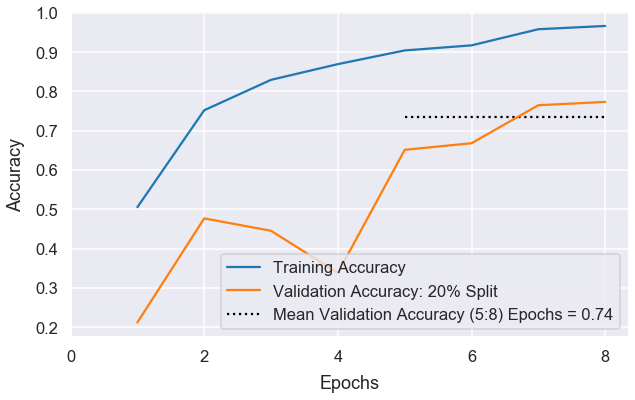

In [11]:
fig, axe = plt.subplots(figsize=(10,6))
sns.lineplot(np.linspace(1,EPOCHS,EPOCHS), history.history['accuracy'], label='Training Accuracy')
sns.lineplot(np.linspace(1,EPOCHS,EPOCHS), history.history['val_accuracy'], label='Validation Accuracy: 20% Split ')
mean_acc = np.mean(history.history['val_accuracy'][5:EPOCHS + 1])
plt.hlines(y=mean_acc, xmin=5, xmax=EPOCHS, linestyle=':', label=f'Mean Validation Accuracy (5:{EPOCHS}) Epochs = {mean_acc:.2f}')
plt.xlabel('Epochs',labelpad=10)
plt.ylabel('Accuracy', labelpad=10)
plt.xticks(np.arange(0,EPOCHS + 2,2))
plt.legend()
# plt.title('InceptionV3 CNN with Augmented Image Data \n Weighted Classes using Scikit-Learn')

In [12]:
# model_history_df = pd.DataFrame.from_dict(history.history)
# model_history_df.to_csv('model_history_inceptionV3_augment'+ '.csv')

In [13]:
# # save model and architecture to single file
# model.save("model_InceptionV3.h5")
# print("Saved model to disk")

In [14]:
# from tensorflow.keras.models import load_model
 
# # load model
# model = load_model('model_InceptionV3.h5')
# # summarize model.
# model.summary()

In [15]:
FOLDER_TO_ACCESS = 'testdata_pp'
data_path = [data for data in all_file_paths if FOLDER_TO_ACCESS in data.lower()]  # searches for data folder and retrieves
test_folder_path = os.path.join(my_dir, data_path[0])  # joins data folder and current work dir to get picture path

In [16]:
test_folder_path

'C:\\Users\\adamc\\Jupyter\\ECE-524-Neural_Networks\\Competition_Project\\TestData_PP'

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_it = test_datagen.flow_from_directory('.', classes=['TestData_PP'],  # expects subfolder! Use root then classes is folder
                                           target_size=(299, 299),
                                           shuffle=False,
                                           batch_size=1)

Found 200 images belonging to 1 classes.


In [18]:
prediction_results = model.predict(test_it,
                                  steps=test_it.n)

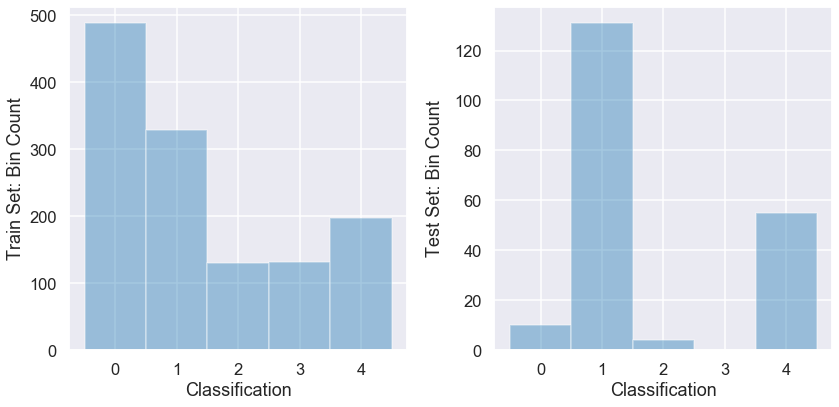

In [35]:
sparse_test = np.argmax(prediction_results,axis = 1)  # returns index of largest value

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
bin_val = np.arange(0, 6, 1) - 0.5
sns.distplot(df_Train['annotation'], kde=False, bins=bin_val, ax=axes[0])
sns.distplot(sparse_test, kde=False, bins=bin_val, ax=axes[1])
# plt.xlim(-0.1,4.1)
plt.xticks(np.arange(0,5, 1))

axes[0].set_ylabel("Train Set: Bin Count")
axes[1].set_ylabel("Test Set: Bin Count", labelpad=10)

axes[0].set_xlabel('Classification')
axes[1].set_xlabel('Classification')
plt.tight_layout()

In [22]:
test_dict = {'annotation': sparse_test}
df_test = pd.DataFrame.from_dict(test_dict)
pd.DataFrame.to_csv(df_test, 'Test_Results_Sparse_learn_evendist.csv')

In [21]:
sparse_test

array([1, 4, 4, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 4, 1, 1, 4, 4, 1, 1, 1, 1, 4, 2, 1,
       1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 4, 4, 1, 1, 4, 1, 4, 4, 1, 1, 1, 1, 1, 4, 0, 1, 4, 1, 1,
       1, 4, 4, 1, 1, 1, 1, 0, 1, 4, 1, 1, 4, 4, 4, 0, 1, 1, 4, 1, 1, 0,
       1, 0, 4, 1, 4, 4, 1, 1, 1, 4, 1, 1, 0, 4, 1, 1, 4, 4, 1, 1, 1, 4,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 4, 0, 1, 1, 1, 1, 1, 4, 4, 1, 1, 0, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 4, 4, 4, 1, 4, 4, 1, 1, 4, 2,
       1, 4, 4, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 4, 1,
       1, 1], dtype=int64)

In [33]:
def vectorize(j):
    e = np.zeros((5))
    e[j] = 1.0
    return e


hot_code_results = np.zeros(prediction_results.shape)

for i in range(prediction_results.shape[0]):
    hot_code_results[i,:] = vectorize(sparse_test[i])

df_test_hot_encode = pd.DataFrame(hot_code_results, columns=None, index=None)

df_test_hot_encode.to_csv('results_c2.csv')